# Analysis notebook
## 20200213:
### this notebook
- segments timelapses
- tracks cells
- visualizes segmentation / tracking result
- plots shape features over time from selected track numbers

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from tqdm import tqdm

from stardist import random_label_cmap, _draw_polygons
from stardist.models import StarDist2D

import tifffile

np.random.seed(6)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.
/Users/marvin/miniconda3/envs/stardist/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/marvin/miniconda3/envs/stardist/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/marvin/miniconda3/envs/stardist/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/m

# Load stardist model for segmentation

In [2]:
model = StarDist2D(None, name='stardist_full_movie_g22_r128', basedir='models')

Instructions for updating:
Colocations handled automatically by placer.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.534533, nms_thresh=0.3.


## Segmentation and feature extraction
This step assumes that a large video has previously been opened in Fiji as a virtual stack and exported as an Image sequence. Images should be split by time and channel (should be automatic Fiji setting)

To configure:
- set filename patterns below
- set timepoints to process

Note:
- timepoints are processed individually and results are saved for each tp
- in case the processing is interrupted for some reason, restarting should consider already saved data
- for processing from scratch, delete '_labels.tif' and '_info.csv' files

In [4]:
# segmentation and tracking processing

fn_pattern = "data/2020-01-21/2020-01-21_pMS48+SrEpac_escape_movie_full_t%(t)03d_c%(c)03d.tif"

# for storing segmentation labels
# format: tif image
labels_fn_pattern = "data/2020-01-21/2020-01-21_pMS48+SrEpac_escape_movie_full_t%(t)03d_labels.tif"

# for storing info extracted from labels (such as positions and aspect ratios of cells)
# format: csv (pandas dataframe)
info_fn_pattern = "data/2020-01-21/2020-01-21_pMS48+SrEpac_escape_movie_full_t%(t)03d_info.csv"

# file to save combined track info
final_track_result_fn = "data/2020-01-21/2020-01-21_pMS48+SrEpac_escape_movie_full_tracks_info.csv"

times = range(1,263)
channels = [1,2]

import os
from scipy import ndimage
from skimage import measure
import pandas as pd

# df = pd.DataFrame(columns=['t','l','x','y'])

info_dfs = []
for t in tqdm(times[:2]):
# for t in times[:]:
#     print(t)

    curr_label_file = labels_fn_pattern %{'t': t}
    
    # load segmentation from file if available
    if os.path.exists(curr_label_file):
        labels = tifffile.imread(curr_label_file)
        
    # otherwise compute using stardist
    else:
        img = np.array([tifffile.imread(fn_pattern %{'t': t, 'c': c}) for c in channels])
        img = np.moveaxis(img,0,-1)
        #img = img[0:500,0:500]
        img = normalize(img, 1,99.8, axis=(0,1))
        n_tiles = [np.ceil(i / 1000) for i in img.shape]
        labels, details = model.predict_instances(img,n_tiles=n_tiles,show_tile_progress=False)
        tifffile.imsave(curr_label_file,labels)
    
    curr_info_file = info_fn_pattern %{'t': t}
    
    # load info from file if available
    if os.path.exists(curr_info_file):
        info_df = pd.read_csv(curr_info_file)
        
    # otherwise process labels
    else:
        centers = ndimage.measurements.center_of_mass(labels,labels,range(1,labels.max()+1))
        if not centers: continue

        # process cells
        p = measure.regionprops_table(labels,properties=['centroid','area','eccentricity','perimeter','minor_axis_length','major_axis_length','label'])
        p['t'] = t
        p['aspect_ratio'] = p['major_axis_length'] / p['minor_axis_length']
        # https://en.wikipedia.org/wiki/Shape_factor_(image_analysis_and_microscopy)
        p['circularity'] = 4*np.pi*p['perimeter'] / p['area']**2
        info_df = pd.DataFrame(p)
        info_df.to_csv(curr_info_file,index=False)
    
    info_dfs.append(info_df)
df = pd.concat(info_dfs,ignore_index=True)
    
# track cells over time
import trackpy as tp
tdf = tp.link_df(df,50,t_column='t',pos_columns=['centroid-0','centroid-1'])
tdf.to_csv(final_track_result_fn,index=False)

Frame 2: 239 trajectories present.


# Repeat above for an additional videos
Append copies of below cell for even more videos 

In [16]:
# segmentation and tracking processing

fn_pattern = "data/attempt2/attempt 2 - better - Experiment-8378.czi - attempt 2 - better - Experiment-8378_t%(t)03d_c%(c)03d.tif"

# for storing segmentation labels
# format: tif image
labels_fn_pattern = "data/attempt2/attempt2_t%(t)03d_labels.tif"

# for storing info extracted from labels (such as positions and aspect ratios of cells)
# format: csv (pandas dataframe)
info_fn_pattern = "data/attempt2/attempt2_t%(t)03d_info.csv"

# file to save combined track info
final_track_result_fn = "data/attempt2/attempt2_tracks_info.csv"

times = range(1,247)
channels = [1,2]

import os
from scipy import ndimage
from skimage import measure
import pandas as pd

# df = pd.DataFrame(columns=['t','l','x','y'])

info_dfs = []
for t in tqdm(times[:]):
# for t in times[:]:
#     print(t)

    curr_label_file = labels_fn_pattern %{'t': t}
    
    # load segmentation from file if available
    if os.path.exists(curr_label_file):
        labels = tifffile.imread(curr_label_file)
        
    # otherwise compute using stardist
    else:
        img = np.array([tifffile.imread(fn_pattern %{'t': t, 'c': c}) for c in channels])
        img = np.moveaxis(img,0,-1)
        #img = img[0:500,0:500]
        img = normalize(img, 1,99.8, axis=(0,1))
        n_tiles = [np.ceil(i / 1000) for i in img.shape]
        labels, details = model.predict_instances(img,n_tiles=n_tiles,show_tile_progress=False)
        tifffile.imsave(curr_label_file,labels)
    
    curr_info_file = info_fn_pattern %{'t': t}
    
    # load info from file if available
    if os.path.exists(curr_info_file):
        info_df = pd.read_csv(curr_info_file)
        
    # otherwise process labels
    else:
        centers = ndimage.measurements.center_of_mass(labels,labels,range(1,labels.max()+1))
        if not centers: continue

        # process cells
        p = measure.regionprops_table(labels,properties=['centroid','area','eccentricity','perimeter','minor_axis_length','major_axis_length','label'])
        p['t'] = t
        p['aspect_ratio'] = p['major_axis_length'] / p['minor_axis_length']
        # https://en.wikipedia.org/wiki/Shape_factor_(image_analysis_and_microscopy)
        p['circularity'] = 4*np.pi*p['perimeter'] / p['area']**2
        info_df = pd.DataFrame(p)
        info_df.to_csv(curr_info_file,index=False)
    
    info_dfs.append(info_df)
df = pd.concat(info_dfs,ignore_index=True)
    
# track cells over time
import trackpy as tp
tdf = tp.link_df(df,50,t_column='t',pos_columns=['centroid-0','centroid-1'])
tdf.to_csv(final_track_result_fn,index=False)

Frame 246: 6 trajectories present.


# Join segmentation results from above and track cells

In [18]:
# to analyse more than one video run the above cell for each video and then combine
final_track_result_fns = [
    "data/2020-01-21/2020-01-21_pMS48+SrEpac_escape_movie_full_tracks_info.csv",
    #"data/2020-01-21/2020-01-21_pMS48+SrEpac_escape_movie_full_tracks_info.csv",
    ]

dfs = []
for fn in final_track_result_fns:
    tmpdf = pd.read_csv(fn)
    if len(dfs):
        tmpdf['particle'] += dfs[-1]['particle'].max()
    dfs.append(tmpdf)
    
combined_tdf = pd.concat(dfs,ignore_index=True)
combined_tdf

,centroid-0,centroid-1,area,eccentricity,perimeter,minor_axis_length,major_axis_length,label,t,aspect_ratio,circularity,particle
0,2094,3036,2320,0.917632,209.923882,34.710280,87.336494,1,1,2.516156,0.000490,0
1,2442,2964,940,0.324685,111.740115,33.687590,35.617257,154,1,1.057281,0.001589,1
2,1812,1423,1111,0.151413,123.740115,37.504197,37.941640,155,1,1.011664,0.001260,2
3,1080,410,1191,0.523885,128.225397,36.061458,42.336125,156,1,1.173999,0.001136,3
4,2216,2062,1211,0.257460,129.296465,38.638503,39.986491,157,1,1.034887,0.001108,4
...,...,...,...,...,...,...,...,...,...,...,...,...
475,2891,1083,858,0.498506,108.325902,30.792735,35.521069,85,2,1.153554,0.001849,50
476,2107,1029,2377,0.764245,190.710678,44.533144,69.051582,86,2,1.550566,0.000424,12
477,1162,3642,816,0.305628,104.325902,31.482661,33.064777,87,2,1.050254,0.001969,239
478,3489,3174,1151,0.510048,127.053824,35.581652,41.367001,119,2,1.162594,0.001205,191


# Visualize segmentations and tracks
- the sliders can be used to navigate time and channels
- this can be used to choose track numbers for further analysis

<IPython.core.display.Javascript object>


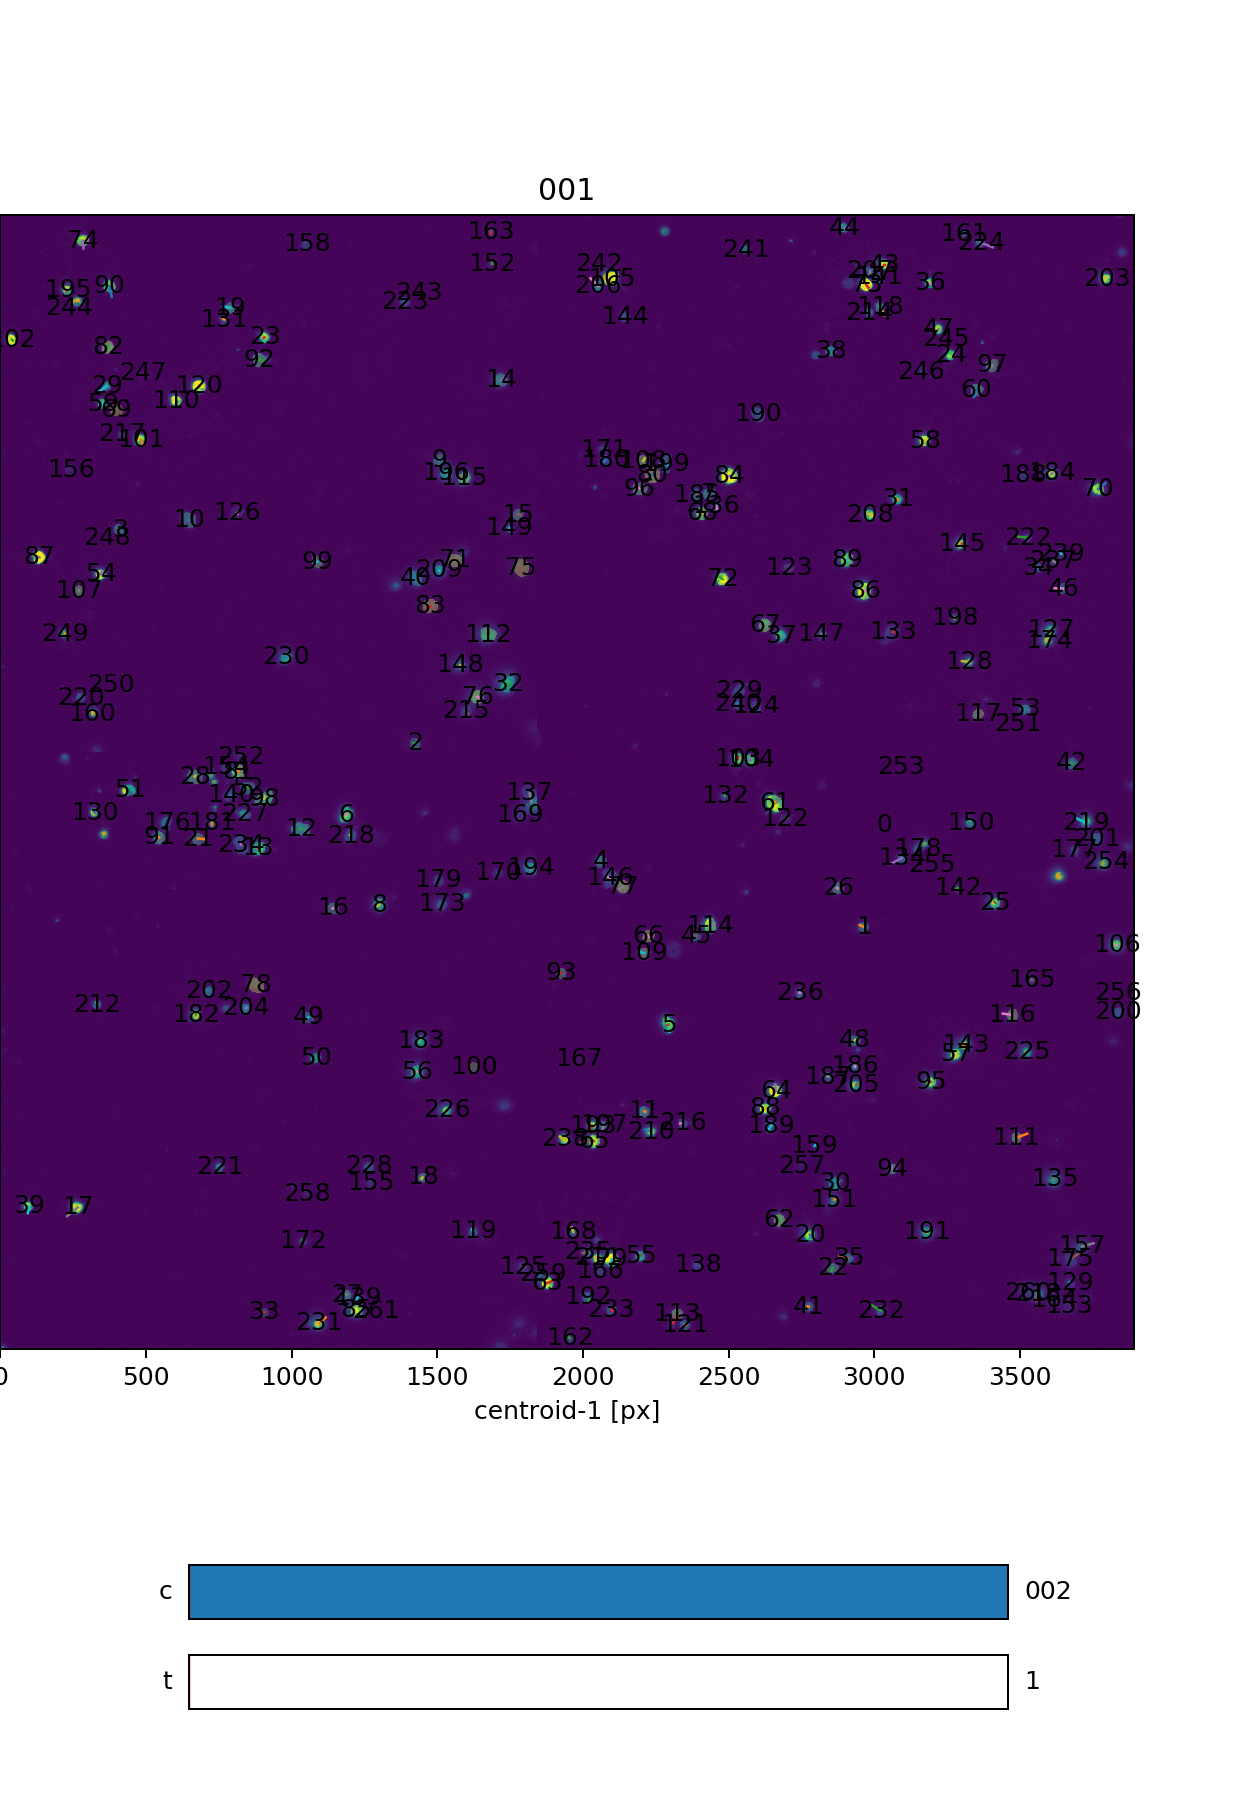

In [19]:
from matplotlib.widgets import Slider

t = 1
c = 1

img = tifffile.imread(fn_pattern %{'t': t, 'c': c})
# img = img[:500,:500]

labels = tifffile.imread(labels_fn_pattern %{'t': t})

fig = plt.figure(figsize=(7,10))
ax = plt.subplot(111)
imsh = ax.imshow(img)
imsh_labels = ax.imshow(labels,alpha=0.3)

plt.subplots_adjust(left=0.0, bottom=0.25)
ax_time = plt.axes([0.15, 0.05, 0.65, 0.03])#, axisbg=axcolor)
ax_ch = plt.axes([0.15, 0.1, 0.65, 0.03])#, axisbg=axcolor)

time_slider = Slider(ax_time, 't', valmin=times[0],valmax=times[-1],valinit=1, valfmt='%01d',closedmax=True, valstep=1)
channel_slider = Slider(ax_ch, 'c', valmin=channels[0],valmax=channels[-1],valinit=0, valfmt='%03d',closedmax=True, valstep=1)

curr_t = [t]
def update(val):
    t = time_slider.val
    c = channel_slider.val
    ax.set_title('%03d' %t)
    img = tifffile.imread(fn_pattern %{'t': t, 'c': c})
#     img = img[:500,:500]
    imsh.set_data(img)
    imsh.set_clim(vmin=np.percentile(img,0.1),vmax=np.percentile(img,99.9))
    
    if t!=curr_t[0]:
        labels = tifffile.imread(labels_fn_pattern %{'t': t})
        imsh_labels.set_data(labels)
        curr_t[0] = t
    
    plt.show()

time_slider.on_changed(update)
channel_slider.on_changed(update)

d = tp.plot_traj(tdf, t_column='t', ax=ax,  label=True, pos_columns=['centroid-1','centroid-0'])

plt.show()

# Plot features over time using track IDs

<IPython.core.display.Javascript object>


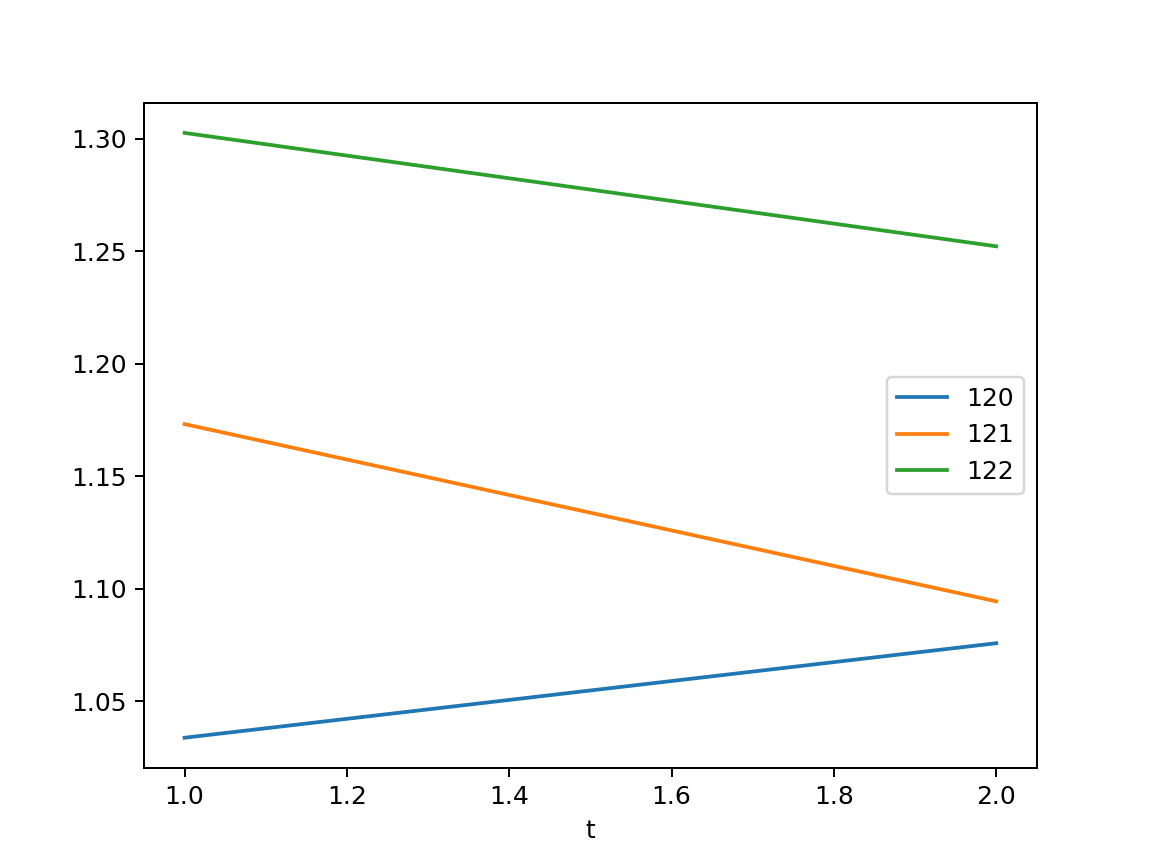

In [32]:
track_ids = [120,121,122] # list of track numbers
feature = 'aspect_ratio' # any of 'eccentricity', 'aspect_ratio', 'circularity'

ax = None
for track_id in track_ids:
    ptdf = tdf[tdf.particle==track_id]
    ax = ptdf.plot(x='t', y=feature, ax=ax, label=track_id)

# Illustrations

In [170]:
# def get_outlines_from_3d_image(ims):
#     res = np.zeros(ims[0].shape,dtype=np.uint16)
#     for t in range(len(ims)):
#         tmpim = ims[t] > 0
#         tmpim = ndimage.binary_dilation(tmpim,iterations=1) ^ tmpim
#         res += tmpim
#     return res
# plt.figure()
# d = tp.plot_traj(tdf, t_column='t', superimpose=get_outlines_from_3d_image(res).T,  label=True)

<IPython.core.display.Javascript object>


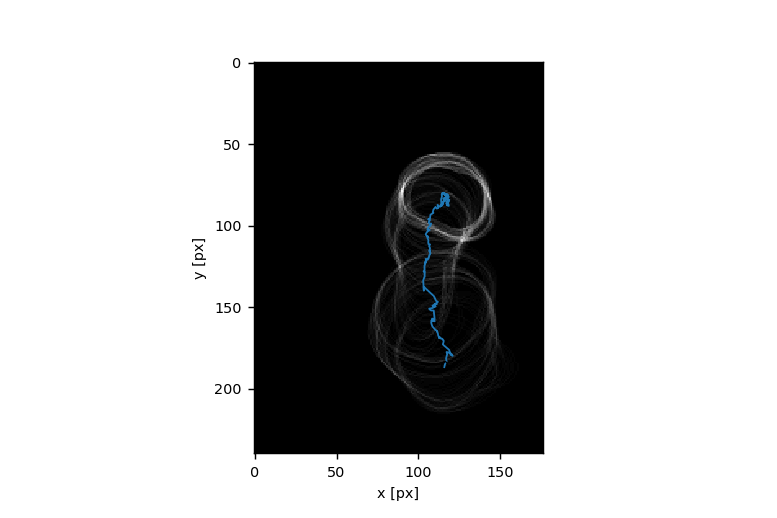

In [171]:
# plt.figure()
# d = tp.plot_traj(tdf, t_column='t', superimpose=res[0].T,  label=True)
